# Global Terrorism Database Analysis Project

This is a project exploring the Global Terrorism Database. A number of the terrorist attacks in the past forty years have not been associated with a particular group, and I am building a model to predict the responsible groups in those instances. The data set has around 160k attacks, each with around 130 different attributes with information about those attacks. The dataset guidebook can be found here: https://www.start.umd.edu/gtd/downloads/Codebook.pdf

In [1]:
# data analysis and wrangling
import re, time
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
GTD_full = pd.read_csv('GTD_data.csv').fillna(np.nan)

# Clean Data Set; intially keep features that seem relevant, take out text-based features
keep_cols = ['iyear','crit1','crit2','crit3','multiple','country','region', \
            'attacktype1','suicide','weaptype1', 'targtype1','gname']
GTD_cut = GTD_full[keep_cols]
GTD_cut.head()

/Users/abhisaar/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,61,62,66,116,117,123) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,iyear,crit1,crit2,crit3,multiple,country,region,attacktype1,suicide,weaptype1,targtype1,gname
0,1970,1,1,1,0,58,2,1,0,13,14,MANO-D
1,1970,1,1,1,0,130,1,6,0,13,7,23rd of September Communist League
2,1970,1,1,1,0,160,5,1,0,13,10,Unknown
3,1970,1,1,1,0,78,8,3,0,6,7,Unknown
4,1970,1,1,1,0,101,4,7,0,8,7,Unknown


# Preliminary Data Analysis

In [3]:
GTD_cut.info()
GTD_cut.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156772 entries, 0 to 156771
Data columns (total 12 columns):
iyear          156772 non-null int64
crit1          156772 non-null int64
crit2          156772 non-null int64
crit3          156772 non-null int64
multiple       156772 non-null int64
country        156772 non-null int64
region         156772 non-null int64
attacktype1    156772 non-null int64
suicide        156772 non-null int64
weaptype1      156772 non-null int64
targtype1      156772 non-null int64
gname          156772 non-null object
dtypes: int64(11), object(1)
memory usage: 14.4+ MB


,iyear,crit1,crit2,crit3,multiple,country,region,attacktype1,suicide,weaptype1,targtype1
count,156772.000000,156772.000000,156772.000000,156772.000000,156772.000000,156772.000000,156772.000000,156772.000000,156772.000000,156772.000000,156772.000000
mean,2000.474083,0.988327,0.992690,0.882919,0.130374,133.087401,6.970097,3.187081,0.030433,6.408587,8.305112
std,12.982397,0.107410,0.085186,0.321518,0.336716,113.946290,2.967803,1.870064,0.171775,2.130785,6.642518
min,1970.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,1989.000000,1.000000,1.000000,1.000000,0.000000,69.000000,5.000000,2.000000,0.000000,5.000000,3.000000
50%,2005.000000,1.000000,1.000000,1.000000,0.000000,101.000000,6.000000,3.000000,0.000000,6.000000,4.000000
75%,2013.000000,1.000000,1.000000,1.000000,0.000000,160.000000,10.000000,3.000000,0.000000,6.000000,14.000000
max,2015.000000,1.000000,1.000000,1.000000,1.000000,1004.000000,12.000000,9.000000,1.000000,13.000000,22.000000


In [4]:
GTD_cut.country.describe()

count    156772.000000
mean        133.087401
std         113.946290
min           4.000000
25%          69.000000
50%         101.000000
75%         160.000000
max        1004.000000
Name: country, dtype: float64

In [5]:
# Check how many unique categories are in each feature
for x in GTD_cut:
    print(x, len(np.unique(GTD_cut[x])))

iyear 45
crit1 2
crit2 2
crit3 2
multiple 2
country 206
region 12
attacktype1 9
suicide 2
weaptype1 12
targtype1 22
gname 3290


# Data Wrangling

In [6]:
# Change year variable into 5-year ranges
GTD_cut['iyear'] = pd.cut(GTD_cut['iyear'], 8).astype(str)
ranges = np.unique(GTD_cut['iyear'])
ranges = {x: y for (x,y) in zip(ranges, range(len(ranges)))}
GTD_cut = GTD_cut.replace({'iyear': ranges})

/Users/abhisaar/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


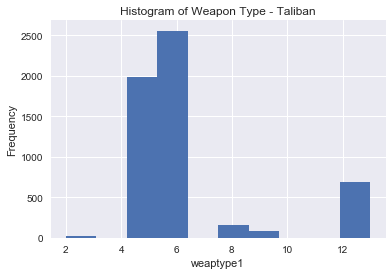

In [7]:
group = 'Taliban'
feature = 'weaptype1'
GTD_cut.loc[GTD_cut['gname'] == group][feature].hist()
plt.title('Histogram of Weapon Type - ' + group)
plt.xlabel(feature)
plt.ylabel('Frequency')

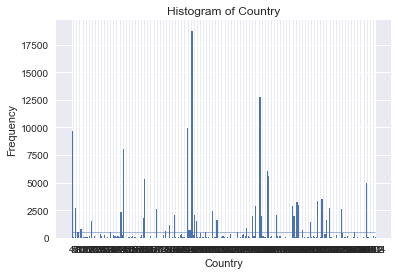

In [8]:
unique, counts = np.unique(GTD_cut['country'], return_counts=True)
countries = dict(zip(unique, counts))
plt.bar(range(len(countries)), countries.values(), align='center')
plt.xticks(range(len(countries)), countries.keys())
line = np.array([500 for x in range(len(countries))])
plt.plot(line, linewidth=.5)
plt.title('Histogram of Country')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Consolidate country values
GTD_cut['country'] = GTD_cut['country'].apply(lambda x: 0 if countries[x] < 500 else x)

In [10]:
# Change categorical strings to ints
unique = np.unique(GTD_cut['gname'])
groups = {x: y for (x,y) in zip(unique, range(1,len(unique)+1))}
inv_groups = {y: x for (x,y) in zip(unique, range(1,len(unique)+1))}
GTD_cut = GTD_cut.replace({'gname': groups})

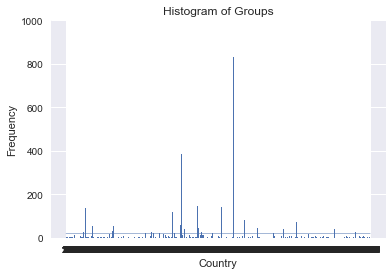

In [11]:
# Graph frequency of groups
unique, counts = np.unique(GTD_cut['gname'], return_counts=True)
group_freq = dict(zip(unique, counts))
plt.bar(range(len(group_freq)), group_freq.values(), align='center')
plt.xticks(range(len(group_freq)), group_freq.keys())
line = np.array([20 for x in range(len(group_freq))])
plt.plot(line, linewidth=.5)
plt.title('Histogram of Groups')
plt.xlabel('Country')
plt.ylabel('Frequency')
axes = plt.gca()
axes.set_ylim([0,1000])
plt.show()

In [12]:
# Consolidate group values
GTD_cut['gname'] = GTD_cut['gname'].apply(lambda x: 0 if group_freq[x] < 20 else x)

In [13]:
# Check how many unique categories are in each feature
for x in GTD_cut:
    print(x, len(np.unique(GTD_cut[x])))

iyear 8
crit1 2
crit2 2
crit3 2
multiple 2
country 44
region 12
attacktype1 9
suicide 2
weaptype1 12
targtype1 22
gname 352


In [14]:
# Convert categorical features into dummy matrices
cat_features = ['country','region', 'attacktype1','weaptype1', 'targtype1']

for feature in cat_features:
    GTD_cut = pd.concat([GTD_cut, pd.get_dummies(GTD_cut[feature], prefix=(feature))], axis=1).drop(feature, 1)

# Model Training and Testing

In [15]:
GTD_known = GTD_cut[GTD_cut.gname != groups["Unknown"]]
GTD_unknown = GTD_cut[GTD_cut.gname == groups["Unknown"]]

X = GTD_known.drop('gname', axis=1)
y = GTD_known.gname
#y = pd.get_dummies(GTD_known.gname, prefix=('gname'))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train_df = X_train.copy()
train_df = pd.concat([train_df, y_train], axis=1)

In [80]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [81]:
# Print Accuracies
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
print("Accuracy_train: {}%".format(acc_log))

acc_log = round(logreg.score(X_test, y_test) * 100, 2)
print("Accuracy_test: {}%".format(acc_log))

Accuracy_train: 64.31%
Accuracy_test: 62.71%


In [82]:
# Check correlations
corr = pd.DataFrame({"Feature": X_train.columns, "Correlation": logreg.coef_.mean(axis=0)})
corr['sort'] = corr.Correlation.abs()
corr.sort_values(by='sort', ascending=False).drop('sort', axis=1)

,Correlation,Feature
1,-1.958655,crit1
2,-1.673282,crit2
3,-1.031777,crit3
86,-0.832950,targtype1_4
74,-0.623034,weaptype1_5
82,-0.617361,weaptype1_13
75,-0.505708,weaptype1_6
77,-0.501948,weaptype1_8
52,-0.496076,region_3
62,-0.468972,attacktype1_1


In [ ]:
svc = SVC()
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
print("Accuracy_train: {}%".format(acc_svc))

acc_svc = round(svc.score(X_test, y_test) * 100, 2)
print("Accuracy_test: {}%".format(acc_svc))

In [16]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [17]:
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
print("Accuracy_train: {}%".format(acc_knn))

acc_knn = round(knn.score(X_test, y_test) * 100, 2)
print("Accuracy_test: {}%".format(acc_knn))

Accuracy_train: 69.57%
Accuracy_test: 63.58%


In [18]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [19]:
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
print("Accuracy_train: {}%".format(acc_sgd))

acc_sgd = round(sgd.score(X_test, y_test) * 100, 2)
print("Accuracy_test: {}%".format(acc_sgd))

Accuracy_train: 58.25%
Accuracy_test: 57.52%


In [20]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [21]:
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
print("Accuracy_train: {}%".format(acc_decision_tree))

acc_decision_tree = round(decision_tree.score(X_test, y_test) * 100, 2)
print("Accuracy_test: {}%".format(acc_decision_tree))

Accuracy_train: 77.03%
Accuracy_test: 66.09%


In [22]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [23]:
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
print("Accuracy_train: {}%".format(acc_random_forest))

acc_random_forest = round(random_forest.score(X_test, y_test) * 100, 2)
print("Accuracy_test: {}%".format(acc_random_forest))

Accuracy_train: 77.03%
Accuracy_test: 66.67%


In [24]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [25]:
acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
print("Accuracy_train: {}%".format(acc_linear_svc))

acc_linear_svc = round(linear_svc.score(X_test, y_test) * 100, 2)
print("Accuracy_test: {}%".format(acc_linear_svc))

Accuracy_train: 65.22%
Accuracy_test: 63.0%


In [ ]:
# Predict Using Best Model
Y_pred = random_forest.predict(GTD_unknown.drop('gname', axis=1))